StyleGAN3

In [1]:
#@markdown ###Check GPU type
#@markdown Factory reset runtime if you don't have the desired GPU.
#@markdown - V100 = Excellent (*Available only for Colab Pro users*)
#@markdown - P100 = Very Good
#@markdown - T4 = Good (*preferred*)
#@markdown - K80 = Meh
#@markdown - P4 = (*Not Recommended*)

!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-eac41d9a-9a5d-5a4e-483f-1b946891607d)


In [9]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

# TODO: conditional install
#!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html


import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

1.10.0+cu111
0.11.1+cu111
     |████████████████████████████████| 108 kB 5.4 MB/s 


In [4]:
import sys,io, os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
import unicodedata
import re
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
clear_output()

In [ ]:
!pip install ninja einops
import clip
from einops import rearrange

In [5]:
NAME = 'stylegan3'
GDRIVE_MOUNT = '/content/drive'
BASE_DIR = f'{GDRIVE_MOUNT}/MyDrive/colab/'
CODE_DIR = f'{BASE_DIR}{NAME}/'

In [6]:
# Connect Google Drive
from google.colab import files, drive
drive.mount(GDRIVE_MOUNT)

Mounted at /content/drive


In [7]:
if os.path.isdir(CODE_DIR):
    %cd {CODE_DIR}
    !git pull
else:
    !git clone https://github.com/ManuelKugelmann/stylegan3-fun.git {CODE_DIR}
    %cd {CODE_DIR}

/content/drive/MyDrive/colab/stylegan3
Already up to date.


Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl"...
Generating image for seed 373 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


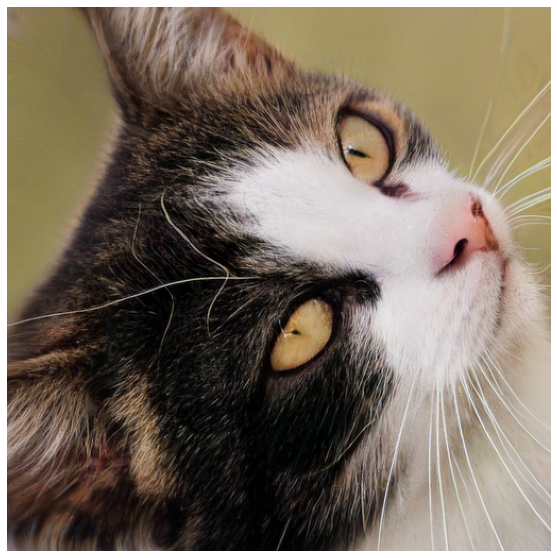

In [14]:
#@title Generate an image
# based on https://colab.research.google.com/drive/1BXNHZBai-pXtP-ncliouXo_kUiG1Pq7M
#@markdown StyleGAN3 pre-trained models for config T (translation equiv.) and config R (translation and rotation equiv.)
seed = 373 #@param {type:"slider", min:0, max:9999, step:1}

baselink ='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/'
model = "stylegan3-r-afhqv2-512x512.pkl" #@param ["stylegan3-r-afhqv2-512x512.pkl", "stylegan3-r-ffhq-1024x1024.pkl", "stylegan3-r-ffhqu-1024x1024.pkl","stylegan3-r-ffhqu-256x256.pkl","stylegan3-r-metfaces-1024x1024.pkl","stylegan3-r-metfacesu-1024x1024.pkl","stylegan3-t-afhqv2-512x512.pkl","stylegan3-t-ffhq-1024x1024.pkl","stylegan3-t-ffhqu-1024x1024.pkl","stylegan3-t-ffhqu-256x256.pkl","stylegan3-t-metfaces-1024x1024.pkl","stylegan3-t-metfacesu-1024x1024.pkl"]

# Generate an image using pre-trained model 
!python gen_images.py --outdir='/content/stylegan3/out/' --trunc=1 \
 --seeds=$seed --network=$baselink$model

plt.figure(figsize=(10,10))
img = Image.open('/content/stylegan3/out/seed%04d.png' % seed);
plt.imshow(img);
plt.axis('off');

CLIP-Stylegan3 based on https://colab.research.google.com/github/ouhenio/StyleGAN3-CLIP-notebook/blob/main/StyleGAN3%2BCLIP.ipynb

In [19]:
#@markdown #**Model selection** 🎭
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.

#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

model_name = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "Wikiart", "Landscapes"]

#@markdown ---

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(tuple):
    url_or_path = tuple[0]
    if "drive.google" in url_or_path:
        basename = tuple[1]
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" in url_or_path:
            path_id = url_or_path.split("id=")[-1]
            !gdown --id '{path_id}'
        else:
            !wget -c '{url_or_path}'
        return basename

model_info = {
    "FFHQ": (base_url + "stylegan3-t-ffhqu-1024x1024.pkl", ),
    "MetFaces": (base_url + "stylegan3-r-metfacesu-1024x1024.pkl", ),
    "AFHQv2": (base_url + "stylegan3-t-afhqv2-512x512.pkl", ),
    "Wikiart": ("https://drive.google.com/u/0/open?id=18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj", "wikiart-1024-stylegan3-t-17.2Mimg.pkl"),
    "Landscapes": ("https://drive.google.com/u/0/open?id=14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1", "lhq-256-stylegan3-t-25Mimg.pkl")
}

basename = fetch_model(model_info[model_name])

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

with open(basename, 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

Using device: cuda:0


Setting up PyTorch plugin "bias_act_plugin"... Done.


In [ ]:
#@markdown #**Parameters** ✍️
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

texts = "Lord of the Rings"#@param {type:"string"}
steps = 300#@param {type:"number"}
seed = 14#@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]

In [ ]:
#@markdown #**Run the model** 🚀

# Actually do the run

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run(timestring):
  torch.manual_seed(seed)

  # Init
  # Sample 32 inits and choose the one closest to prompt

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    # print(losses)
    # print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass